In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import train_test_split

# Algorithms to be tested
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from lightgbm import LGBMRegressor

# Metrics to be used
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.simplefilter("ignore")
sns.set_theme()

## 1. Data Preprocesing

In order to decide which offer should be presented to which customer, we need to know the offer that would influence their spending behavior the most. We hypothesize that the amount of this influence each offer has on spending amount is a function of the customer profile attributes and offer attributes.

The objective of the processing in this section is to list each distinct offer presented to each customer, along with offer attributes, profile attributes, and offer outcome; so that the relationships between them can be investigated.

### Offers (portfolio.json)

In [2]:
# Read portfolio.json
offers = pd.read_json('data/portfolio.json', lines=True)

Encode `channels` and `offer_type` columns as dummy variables.

In [3]:
dummy_columns_from_channels = pd.get_dummies(pd.DataFrame([value for value in offers.channels]), prefix="channel").groupby(level=0, axis=1).sum()
dummy_columns_from_offer_type = pd.get_dummies(offers.offer_type, prefix="offer_type")

# Add them to the original df
offers = pd.concat([offers, dummy_columns_from_channels, dummy_columns_from_offer_type], axis=1)

# Drop the channels and offer_type columns, put the id column first
offers = offers[['id', 'reward', 'difficulty', 'duration', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web', 'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']]

# Preview what we got after this transformation
offers.head()

,id,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0


The unit of offer duration in this data is days but we should convert it to hours to match the unit of time in transcript.

In [4]:
# Convert the offer duration from days to hours so that it matches the unit used in the transcript
offers.duration = offers.duration.apply(lambda x: 24 * x)

# View what we got after this transformation
offers

,id,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,168,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,120,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,96,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,240,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,168,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,240,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,0,72,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,168,1,1,0,1,0,1,0


### Profile (profile.json)

In [5]:
# Read profile.json
profile = pd.read_json('data/profile.json', lines=True)

# Preview what we got after this transformation
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


The profiles with age 118 is an outliner we assume is a mistake, so we will drop those rows.

In [6]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

13% of the profiles don't have a gender value. We will drop these profiles as well.

In [7]:
round(profile.gender.isnull().sum() / profile.shape[0] * 100)

13

Before we drop them, we will keep a list of profiles ids we are dropping as they will need to be removed from the transcript as well.

In [8]:
profiles_to_be_dropped = profile[(profile.age == 118) | (profile.gender.isnull())].id.to_list()
profiles_to_be_dropped[:5]

['68be06ca386d4c31939f3a4f0e3dd783',
 '38fe809add3b4fcf9315a9694bb96ff5',
 'a03223e636434f42ac4c3df47e8bac43',
 '8ec6ce2a7e7949b1bf142def7d0e0586',
 '68617ca6246f4fbc85e91a2a49552598']

Now we can drop the the profiles matching these ids.

In [9]:
profile = profile[profile.id.apply(lambda x: x not in profiles_to_be_dropped)].reset_index().drop(columns='index')
profile.head()

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


Dates in the `became_member_on` column will be more useful when converted to profile ages. Since we don't know when this data was collected, we will assume the newest profiles were 0 days old on the day it was collected and we will calculate the rest of `profile_age` column accordingly.

In [10]:
# Convert the became_member_on column to date
profile.became_member_on = pd.to_datetime(profile.became_member_on, format="%Y%m%d")

# Date the newest profile was created
newest_profile_date = profile.became_member_on.max()

# Profile age
profile['profile_age'] = profile.became_member_on.apply(lambda x: (newest_profile_date - x).days)

# Drop the old column
profile.drop(columns='became_member_on', inplace=True)

# Preview what we got after this transformation
profile.head()

,gender,age,id,income,profile_age
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257


Then we will encode the remaining gender values into dummy variables. We don't need the gender_O dummy since we know a row is gender_O if the other two gender columns are 0.
- Male: gender_M = 1 & gender_F = 0
- Female: gender_M = 0 & gender_F = 1
- Other: gender_M = 0 & gender_F = 0

In [11]:
# Get dummy variables
gender_dummies = pd.get_dummies(profile.gender, prefix="gender").drop(columns='gender_O')

# Add them to the original df
profile = pd.concat([profile, gender_dummies], axis=1)

# Drop the original gender column and put the id column first
profile = profile[['id', 'age', 'income', 'profile_age', 'gender_M', 'gender_F']]

# Preview what we got after this transformation
profile.head()

,id,age,income,profile_age,gender_M,gender_F
0,0610b486422d4921ae7d2bf64640c50b,55,112000.0,376,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1
2,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0
3,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0
4,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0


### Transcript (transcript.json)

In [12]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


We will start by dropping the rows that correspond to the profiles we dropped so that we don't need to keep wrangling a larger dataset in the following steps.

In [13]:
transcript = transcript[transcript.person.apply(lambda x: x not in profiles_to_be_dropped)].reset_index().drop(columns='index')
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [14]:
# Create a df with dummy variables from the event column
dummy_columns_from_event = pd.get_dummies(transcript['event'], prefix="event")

# Parse the dictionary in the value column
value_dict_parsed = transcript.value.apply(pd.Series)

# Add the dummy variables and the parsed variables from the value column to the transcript df and drop the original event column
transcript = pd.concat([transcript, dummy_columns_from_event, value_dict_parsed], axis=1).drop(columns=['event', 'value'])
transcript.head()

,person,time,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


The keys in the value column are not consistent, which resulted in two columns: `offer id` and `offer_id`. We will need to merge them but first let's check if there are any rows that have values in both these columns:

In [15]:
transcript[(transcript['offer id'].notnull()) & (transcript['offer_id'].notnull())].shape[0] > 0

False

Since there are none, we can use a simpler logic that fills nulls of the `offer_id` column with the values from the `offer id` column:

In [16]:
# Merge the values in the two columns
transcript['offer_id'] = np.where(transcript['offer_id'].isnull(), transcript['offer id'], transcript['offer_id'])

# We no longer need the 'offer id' column after the merge
transcript.drop(columns='offer id', inplace=True)

# Remove spaces from column names
transcript.rename(columns={
    "event_offer completed": "event_offer_completed",
    "event_offer received": "event_offer_received", 
    "event_offer viewed": "event_offer_viewed"
    }, inplace=True)

transcript.head()

,person,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


### Offer Instance
We will call each case an offer is presented to a customer an "instance" of that offer. We will aggregate the transactions occured during the validity period of that offer in the `offer_instance` dataframe.

#### Offer Start and End Time
For this aggregation, first we will need a variable that shows the time each presented offer is expired (`offer_end_time`).

In [17]:
offer_instance = transcript[transcript.event_offer_received == 1]

# Rename time column to offer_start_time
offer_instance.rename(columns={'time': 'offer_start_time'}, inplace=True)

# Reorder and drop the unnecessary columns
offer_instance = offer_instance[['offer_id', 'person', 'offer_start_time']]

# Calculate the offer end time for each offer instance
offer_instance['offer_end_time'] = offer_instance.offer_start_time + offer_instance.offer_id.apply(lambda x: offers[offers.id == x]['duration'].values[0])

offer_instance.head()

,offer_id,person,offer_start_time,offer_end_time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,168
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,168
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,120
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0,96
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,240


#### Offer View Time
In the data there are cases where the same offer is presented to the same user at different times, so when searching in the transcript df for when an offer is viewed, we will specify the start and end times of the offer of which we are looking to obtain the view time. If it is not viewed, we will put NaN in that row in the `offer_view_time` column.

In [18]:
# An example of case where the same offer is received twice at different times
transcript[(transcript.person=='0020c2b971eb4e9188eac86d93036a77') & (transcript.offer_id == 'fafdcd668e3743c1bb461111dcafc2a4')]

,person,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,offer_id,reward
1643,0020c2b971eb4e9188eac86d93036a77,0,0,1,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
16090,0020c2b971eb4e9188eac86d93036a77,12,0,0,1,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
27671,0020c2b971eb4e9188eac86d93036a77,54,1,0,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
100346,0020c2b971eb4e9188eac86d93036a77,336,0,1,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
194501,0020c2b971eb4e9188eac86d93036a77,510,1,0,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0


In [19]:
# Returns the view time of the specified offer
def offer_view_time(person_id, offer_id, offer_start, offer_end):
    try:
        # Selector for the offer view logs: (transcript.event_offer_viewed == 1)
        # Selector for the records associated with the given person: (transcript.person == person_id)
        # Selector for the records associated with the given offer: (transcript.offer_id == offer_id)
        # Selector for the records within the given period: (transcript.time >= offer_start) & (transcript.time <= offer_end)
        return transcript[(transcript.event_offer_viewed == 1) & (transcript.person==person_id) & (transcript.offer_id == offer_id) & (transcript.time >= offer_start) & (transcript.time <= offer_end)].time.values[0]
    
    # Catch the error for offer instances that are not viewed
    except:
        return np.nan

In [20]:
offer_instance['offer_view_time'] = offer_instance.apply(lambda x: offer_view_time(x.person, x.offer_id, x.offer_start_time, x.offer_end_time), axis=1)

# Keep the offer end time column at the end
offer_instance = offer_instance[['offer_id', 'person', 'offer_start_time', 'offer_view_time', 'offer_end_time']]

offer_instance.head()

,offer_id,person,offer_start_time,offer_view_time,offer_end_time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,168
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,18.0,168
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,120
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,96
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0,240


#### Spending During an Offer Instance
Here we are interested in finding the amount spent between when an offer is viewed and when it is expired. Later, this will enable us to compare the spending while the customer is aware of an active offer with the spending in other periods.

In [21]:
def person_spending_of_during_period(person_id, period_from, period_to):

    # Selector for the spending logs: (transcript.event_transaction == 1)
    # Selector for the records associated with the given person: (transcript.person == person_id)
    # Selector for the records within the given period: (transcript.time > period_from) & (transcript.time < period_to)
    transcript_segment_selected = transcript[(transcript.event_transaction == 1) & (transcript.person == person_id) & (transcript.time > period_from) & (transcript.time < period_to)]

    # Return the sum of purchase amount in the given period for the given person
    return transcript_segment_selected.amount.sum()

In [22]:
offer_instance['offer_spending'] = offer_instance.apply(lambda x: person_spending_of_during_period(x.person, x.offer_view_time, x.offer_end_time), axis=1)

offer_instance.head()

,offer_id,person,offer_start_time,offer_view_time,offer_end_time,offer_spending
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,168,37.67
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,18.0,168,0.00
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,120,9.54
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,96,0.00
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0,240,12.33


#### Rewards During an Offer Instance
Similarly, we will create a sum of rewards earned with a breakdown per reward instance.

In [23]:
def rewards_of_during_offer_instance(person_id, period_from, period_to):

    # Selector for the reward logs: (transcript.event_offer_completed == 1)
    # Selector for the records associated with the given person: (transcript.person == person_id)
    # Selector for the records within the given period: (transcript.time > period_from) & (transcript.time < period_to)
    transcript_segment_selected = transcript[(transcript.event_offer_completed == 1) & (transcript.person == person_id) & (transcript.time > period_from) & (transcript.time < period_to)]

    # Return the sum of rewards received in the given period for the given person
    return transcript_segment_selected.reward.sum()

In [24]:
# Since rewards are independent of whether a customer viewed an offer or not, we count all rewards from when offer starts
offer_instance['offer_reward'] = offer_instance.apply(lambda x: rewards_of_during_offer_instance(x.person, x.offer_start_time, x.offer_end_time), axis=1)

offer_instance.head()

,offer_id,person,offer_start_time,offer_view_time,offer_end_time,offer_spending,offer_reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,168,37.67,5.0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,18.0,168,0.00,0.0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,120,9.54,5.0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,96,0.00,0.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0,240,12.33,10.0


### Profile (cont'd)

#### Total Spending
We have extracted all information from the logs given in the `transcript.json` df except the spending occured outside of the periods between when the offer is viewed and when it expired. We will add the total spending of each customer to the `profile` df so that this information can be obtained later without needing the transcript df again. For spending events unrelated to the offers, we are only interested in their total so we will not need the `time` value for these records.

In [25]:
# Filter the transcript for purchases
spending_log = transcript[transcript.event_transaction == 1]

# Only leave the columns we are interested in
spending_log = spending_log[['person', 'amount']]

# Aggregate by the sum of spending by person
spending_log = spending_log.groupby('person').sum()

# Rename amount column
spending_log.rename(columns={'amount': 'total_spending'}, inplace=True)

spending_log.head()

,total_spending
person,
0009655768c64bdeb2e877511632db8f,127.60
0011e0d4e6b944f998e987f904e8c1e5,79.46
0020c2b971eb4e9188eac86d93036a77,196.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05
003d66b6608740288d6cc97a6903f4f0,48.34


In [26]:
# Add total_spending to the profile df
profile = pd.merge(profile, spending_log.groupby('person').sum(), left_on='id', right_on='person', how='left')
profile.head()

,id,age,income,profile_age,gender_M,gender_F,total_spending
0,0610b486422d4921ae7d2bf64640c50b,55,112000.0,376,0,1,77.01
1,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1,159.27
2,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0,57.73
3,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0,36.43
4,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0,15.62


#### No Offer Spending
In periods when a customer do not have an active offer and the periods before they have viewed the offer they received, we assume their behavior is not influenced by an offer. We will calculate their spending total during these periods in the `total_no_offer_spending` column.

We cannot calculate this as the difference between `total_spending` and the sum of each `offer_spending` from the `offer_instance` df because there are cases where one transaction is counted as `offer_spending` for multiple offer instances. We have discovered that this is because there are periods where a user has multiple offers valid, therefore they get rewarded for both. For example, in the user log below, we see that at time=516, the $25.59 purchase triggered 3 rewards because the customer had 3 offers active and viewed. While we consider it acceptable to attribute that $25.59 spending to all 3 offers as `offer_spending` in such cases, these cases are the reason why the sum of `offer_spending` is not be meaningful.

In [27]:
transcript[(transcript.person=='088debab4050432abc4817f192abc702') & (transcript.time >= 336) & (transcript.time <= 516)]

,person,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,offer_id,reward
99193,088debab4050432abc4817f192abc702,336,0,1,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
113057,088debab4050432abc4817f192abc702,342,0,0,1,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
134445,088debab4050432abc4817f192abc702,408,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
148951,088debab4050432abc4817f192abc702,414,0,0,1,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
179833,088debab4050432abc4817f192abc702,504,0,1,0,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
190567,088debab4050432abc4817f192abc702,504,0,0,1,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
197216,088debab4050432abc4817f192abc702,516,0,0,0,1,25.59,NaN,NaN
197217,088debab4050432abc4817f192abc702,516,1,0,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
197218,088debab4050432abc4817f192abc702,516,1,0,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
197219,088debab4050432abc4817f192abc702,516,1,0,0,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0


As a workaround for the issue of overlapping offer periods, we will find the periods during which there are no viewed and active offers; then count the spending during those times as `total_no_offer_spending`. Then `total_spending` - `total_no_offer_spending` will give us `total_offer_spending` without overcounting the purchases made during when multiple offers are active and viewed.

In [28]:
# Sort list of each person's offer instances
offer_period = offer_instance.drop(columns=['offer_id', 'offer_start_time', 'offer_spending', 'offer_reward']).sort_values(by='person')

# If the offer is not viewed, we are not intersted in that period
offer_period.dropna(inplace=True)

# Reset index
offer_period.reset_index(inplace=True)

# Drop the old index
offer_period.drop(columns=['index'], inplace=True)

# Sort by offer_view_time
offer_period.sort_values(by=['person', 'offer_view_time'], inplace=True)

offer_period.head()

,person,offer_view_time,offer_end_time
0,0009655768c64bdeb2e877511632db8f,192.0,240
1,0009655768c64bdeb2e877511632db8f,372.0,432
3,0009655768c64bdeb2e877511632db8f,456.0,528
2,0009655768c64bdeb2e877511632db8f,540.0,744
7,0011e0d4e6b944f998e987f904e8c1e5,6.0,96


For each row, we will calculate the no_offer period before it. We will calculate the period after the last row separately and append it. 

In [29]:
# Last no_offer_period of each person will be from their last offer_view_time to the end of transcript
max_event_time = transcript.time.max()
last_period = offer_period.groupby('person').max().drop(columns='offer_view_time')
last_period.rename(columns={'offer_end_time': 'no_offer_from'}, inplace=True)
last_period['no_offer_to'] = max_event_time
last_period.reset_index(inplace=True)
last_period.head()

,person,no_offer_from,no_offer_to
0,0009655768c64bdeb2e877511632db8f,744,714
1,0011e0d4e6b944f998e987f904e8c1e5,672,714
2,0020c2b971eb4e9188eac86d93036a77,528,714
3,0020ccbbb6d84e358d3414a3ff76cffd,672,714
4,003d66b6608740288d6cc97a6903f4f0,648,714


In [30]:
offer_period['offer_end_time_above'] = offer_period.offer_end_time.shift(1)
offer_period['offer_view_time_below'] = offer_period.offer_view_time.shift(-1)
offer_period['person_above'] = offer_period.person.shift(1)
offer_period['person_below'] = offer_period.person.shift(-1)
offer_period['is_first'] = offer_period.person != offer_period.person_above
offer_period['is_last'] = offer_period.person != offer_period.person_below
offer_period.head()

,person,offer_view_time,offer_end_time,offer_end_time_above,offer_view_time_below,person_above,person_below,is_first,is_last
0,0009655768c64bdeb2e877511632db8f,192.0,240,NaN,372.0,NaN,0009655768c64bdeb2e877511632db8f,True,False
1,0009655768c64bdeb2e877511632db8f,372.0,432,240.0,456.0,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,False,False
3,0009655768c64bdeb2e877511632db8f,456.0,528,432.0,540.0,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f,False,False
2,0009655768c64bdeb2e877511632db8f,540.0,744,528.0,6.0,0009655768c64bdeb2e877511632db8f,0011e0d4e6b944f998e987f904e8c1e5,False,True
7,0011e0d4e6b944f998e987f904e8c1e5,6.0,96,744.0,186.0,0009655768c64bdeb2e877511632db8f,0011e0d4e6b944f998e987f904e8c1e5,True,False


In [31]:
def no_offer_from(x):
    if x.is_first:
        return 0
    else:
        return x.offer_end_time_above


def no_offer_to(x):
    if x.is_first:
        return x.offer_view_time
    else:
        return x.offer_view_time

In [32]:
offer_period['no_offer_from'] = offer_period.apply(lambda x: no_offer_from(x), axis=1)
offer_period['no_offer_to'] = offer_period.apply(lambda x: no_offer_to(x), axis=1)
offer_period.drop(columns=['offer_end_time_above', 'offer_view_time_below', 'person_above', 'person_below', 'is_first', 'is_last'], inplace=True)
offer_period.head()

,person,offer_view_time,offer_end_time,no_offer_from,no_offer_to
0,0009655768c64bdeb2e877511632db8f,192.0,240,0.0,192.0
1,0009655768c64bdeb2e877511632db8f,372.0,432,240.0,372.0
3,0009655768c64bdeb2e877511632db8f,456.0,528,432.0,456.0
2,0009655768c64bdeb2e877511632db8f,540.0,744,528.0,540.0
7,0011e0d4e6b944f998e987f904e8c1e5,6.0,96,0.0,6.0


In [33]:
# Add the last no offer periods and sort by offer_view_time
offer_period = pd.concat([offer_period, last_period], ignore_index=True)
offer_period.sort_values(by=['person', 'offer_view_time'], inplace=True)

# no_offer_from will be incorrect for overlapping offers, this prevents no_offer_duration from being negative in those cases
offer_period['no_offer_duration'] = offer_period.apply(lambda x: np.max([x.no_offer_to - x.no_offer_from, 0]), axis=1)
offer_period.head()

,person,offer_view_time,offer_end_time,no_offer_from,no_offer_to,no_offer_duration
0,0009655768c64bdeb2e877511632db8f,192.0,240.0,0.0,192.0,192.0
1,0009655768c64bdeb2e877511632db8f,372.0,432.0,240.0,372.0,132.0
2,0009655768c64bdeb2e877511632db8f,456.0,528.0,432.0,456.0,24.0
3,0009655768c64bdeb2e877511632db8f,540.0,744.0,528.0,540.0,12.0
49126,0009655768c64bdeb2e877511632db8f,NaN,NaN,744.0,714.0,0.0


In [34]:
# Find the spending during period,
# If no_offer_duration == 0, we know it is a 0 spending period regardless of no_offer_from
# Otherwise, aggregate the spending during no offer period
offer_period['no_offer_spending'] = offer_period.apply(lambda x: person_spending_of_during_period(x.person, x.no_offer_from, x.no_offer_to) if x.no_offer_duration > 0 else 0, axis=1)
offer_period.head()

,person,offer_view_time,offer_end_time,no_offer_from,no_offer_to,no_offer_duration,no_offer_spending
0,0009655768c64bdeb2e877511632db8f,192.0,240.0,0.0,192.0,192.0,0.0
1,0009655768c64bdeb2e877511632db8f,372.0,432.0,240.0,372.0,132.0,0.0
2,0009655768c64bdeb2e877511632db8f,456.0,528.0,432.0,456.0,24.0,0.0
3,0009655768c64bdeb2e877511632db8f,540.0,744.0,528.0,540.0,12.0,0.0
49126,0009655768c64bdeb2e877511632db8f,NaN,NaN,744.0,714.0,0.0,0.0


Our no offer period calculations can be verified for the 3 sample profiles selected below.

In [35]:
# For verification
offer_period[(offer_period.person == '73afdeca19e349b98f09e928644610f8') | (offer_period.person == '088debab4050432abc4817f192abc702') | (offer_period.person == '2eeac8d8feae4a8cad5a6af0499a211d')].sort_values(by=['person', 'offer_view_time'])

,person,offer_view_time,offer_end_time,no_offer_from,no_offer_to,no_offer_duration,no_offer_spending
1522,088debab4050432abc4817f192abc702,198.0,288.0,0.0,198.0,198.0,0.00
1523,088debab4050432abc4817f192abc702,342.0,576.0,288.0,342.0,54.0,0.00
1524,088debab4050432abc4817f192abc702,414.0,576.0,576.0,414.0,0.0,0.00
1525,088debab4050432abc4817f192abc702,504.0,672.0,576.0,504.0,0.0,0.00
1526,088debab4050432abc4817f192abc702,588.0,744.0,672.0,588.0,0.0,0.00
49591,088debab4050432abc4817f192abc702,NaN,NaN,744.0,714.0,0.0,0.00
8742,2eeac8d8feae4a8cad5a6af0499a211d,168.0,336.0,0.0,168.0,168.0,0.00
8743,2eeac8d8feae4a8cad5a6af0499a211d,348.0,576.0,336.0,348.0,12.0,0.00
51764,2eeac8d8feae4a8cad5a6af0499a211d,NaN,NaN,576.0,714.0,138.0,0.00
22089,73afdeca19e349b98f09e928644610f8,348.0,576.0,0.0,348.0,348.0,32.72


In [36]:
# For verification
transcript[(transcript.person == '73afdeca19e349b98f09e928644610f8') | (transcript.person == '088debab4050432abc4817f192abc702') | (transcript.person == '2eeac8d8feae4a8cad5a6af0499a211d')].sort_values(by=['person', 'time'])

,person,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,offer_id,reward
47849,088debab4050432abc4817f192abc702,168,0,1,0,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
70584,088debab4050432abc4817f192abc702,198,0,0,1,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
99193,088debab4050432abc4817f192abc702,336,0,1,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
113057,088debab4050432abc4817f192abc702,342,0,0,1,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
134445,088debab4050432abc4817f192abc702,408,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
148951,088debab4050432abc4817f192abc702,414,0,0,1,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
179833,088debab4050432abc4817f192abc702,504,0,1,0,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
190567,088debab4050432abc4817f192abc702,504,0,0,1,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
197216,088debab4050432abc4817f192abc702,516,0,0,0,1,25.59,NaN,NaN
197217,088debab4050432abc4817f192abc702,516,1,0,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0


In [37]:
# Aggregate the no_offer_spending column by person
no_offer_spending = offer_period.groupby('person').sum().drop(columns=['offer_view_time', 'offer_end_time', 'no_offer_from', 'no_offer_to', 'no_offer_duration'])
no_offer_spending.head()


,no_offer_spending
person,
0009655768c64bdeb2e877511632db8f,0.00
0011e0d4e6b944f998e987f904e8c1e5,13.49
0020c2b971eb4e9188eac86d93036a77,81.29
0020ccbbb6d84e358d3414a3ff76cffd,16.27
003d66b6608740288d6cc97a6903f4f0,6.41


In [38]:
# Add these sums as total_no_offer_spending to the profile df
profile = pd.merge(
    left=profile,
    right=no_offer_spending,
    left_on='id',
    right_on='person',
    how='left'
).rename(columns={'no_offer_spending':'total_no_offer_spending'})
profile.head()

,id,age,income,profile_age,gender_M,gender_F,total_spending,total_no_offer_spending
0,0610b486422d4921ae7d2bf64640c50b,55,112000.0,376,0,1,77.01,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1,159.27,23.93
2,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0,57.73,39.31
3,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0,36.43,0.00
4,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0,15.62,0.00


In [39]:
# We can't make any inferences about offer influence for the customers who did not make purchases so we are dropping them
profile.dropna(inplace=True)

#### Offer Spending
We will calculate the customer spending total during the periods after the customer sees an offer and before that offer expires in the `total_offer_spending` column.

In [40]:
# Add total_offer_spending to the profile df
profile['total_offer_spending'] = profile.total_spending - profile.total_no_offer_spending
profile.head()

,id,age,income,profile_age,gender_M,gender_F,total_spending,total_no_offer_spending,total_offer_spending
1,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1,159.27,23.93,135.34
2,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0,57.73,39.31,18.42
3,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0,36.43,0.00,36.43
4,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0,15.62,0.00,15.62
5,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,318,0,1,85.55,15.95,69.60


#### Spending Rates
In order to compare the customer spending during and out of the offer periods, we need to normalize them by obtaining the spending rates instead of the total amounts. To calculate spending rates from totals, we need the number of days each person had an active offer they had viewed (`days_with_offer`) and the the number of days they have not seen any offers (`days_without_offer`).

In [41]:
# Aggregate the no_offer_duration column by person
no_offer_duration = offer_period.groupby('person').sum().drop(columns=['offer_view_time', 'offer_end_time', 'no_offer_from', 'no_offer_to', 'no_offer_spending'])

# Rename
no_offer_duration.rename(columns={'no_offer_duration': 'days_without_offer'}, inplace=True)

# Convert hours to days
no_offer_duration['days_without_offer'] = no_offer_duration['days_without_offer'] / 24

no_offer_duration.head()

,days_without_offer
person,
0009655768c64bdeb2e877511632db8f,15.00
0011e0d4e6b944f998e987f904e8c1e5,7.50
0020c2b971eb4e9188eac86d93036a77,16.00
0020ccbbb6d84e358d3414a3ff76cffd,13.50
003d66b6608740288d6cc97a6903f4f0,13.75


In [42]:
# Add these sums as total_no_offer_spending to the profile df
profile = pd.merge(
    left=profile,
    right=no_offer_duration,
    left_on='id',
    right_on='person',
    how='left'
)
profile.head()

,id,age,income,profile_age,gender_M,gender_F,total_spending,total_no_offer_spending,total_offer_spending,days_without_offer
0,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1,159.27,23.93,135.34,13.25
1,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0,57.73,39.31,18.42,11.25
2,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0,36.43,0.00,36.43,3.75
3,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0,15.62,0.00,15.62,13.25
4,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,318,0,1,85.55,15.95,69.60,6.00


Since we know this data covers a 30-day period, it is easier to calculate `days_with_offer`:

In [43]:
profile['days_with_offer'] = 30 - profile.days_without_offer
profile.head()

,id,age,income,profile_age,gender_M,gender_F,total_spending,total_no_offer_spending,total_offer_spending,days_without_offer,days_with_offer
0,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1,159.27,23.93,135.34,13.25,16.75
1,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0,57.73,39.31,18.42,11.25,18.75
2,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0,36.43,0.00,36.43,3.75,26.25
3,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0,15.62,0.00,15.62,13.25,16.75
4,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,318,0,1,85.55,15.95,69.60,6.00,24.00


Now we can calculate the spending rates `no_offer_spending_rate` and `offer_spending_rate`:

In [44]:
profile['no_offer_spending_rate'] = profile.total_no_offer_spending / profile.days_without_offer
profile['offer_spending_rate'] = profile.total_offer_spending / profile.days_with_offer
profile.head()

,id,age,income,profile_age,gender_M,gender_F,total_spending,total_no_offer_spending,total_offer_spending,days_without_offer,days_with_offer,no_offer_spending_rate,offer_spending_rate
0,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1,159.27,23.93,135.34,13.25,16.75,1.806038,8.080000
1,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0,57.73,39.31,18.42,11.25,18.75,3.494222,0.982400
2,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0,36.43,0.00,36.43,3.75,26.25,0.000000,1.387810
3,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0,15.62,0.00,15.62,13.25,16.75,0.000000,0.932537
4,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,318,0,1,85.55,15.95,69.60,6.00,24.00,2.658333,2.900000


#### Average Offer Influence
Now we can create a variable named `average_offer_influence` that represents the difference between the spending rate with the customer having viewed and active offer and the spending rate at other times.

In [45]:
profile['average_offer_influence'] = profile.offer_spending_rate - profile.no_offer_spending_rate
profile.head()

,id,age,income,profile_age,gender_M,gender_F,total_spending,total_no_offer_spending,total_offer_spending,days_without_offer,days_with_offer,no_offer_spending_rate,offer_spending_rate,average_offer_influence
0,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,443,0,1,159.27,23.93,135.34,13.25,16.75,1.806038,8.080000,6.273962
1,e2127556f4f64592b11af22de27a7932,68,70000.0,91,1,0,57.73,39.31,18.42,11.25,18.75,3.494222,0.982400,-2.511822
2,389bc3fa690240e798340f5a15918d5c,65,53000.0,167,1,0,36.43,0.00,36.43,3.75,26.25,0.000000,1.387810,1.387810
3,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,257,1,0,15.62,0.00,15.62,13.25,16.75,0.000000,0.932537,0.932537
4,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,318,0,1,85.55,15.95,69.60,6.00,24.00,2.658333,2.900000,0.241667


### Offer Instance (cont'd)
Now that we know the spending rates of each customer without an offer and their average spending rate during the period they received any offers, we can calculate the spending rates during each offer and evaluate the influence of each offer.

We will start by adding the `offer_spending_rate` variable which represents the daily spending for an offer instance between the time it was viewed and the time it expired.

In [46]:
# Also divided by 24 to obtain the daily spending rate in $/day
offer_instance['offer_spending_rate'] = offer_instance.offer_spending / ((offer_instance.offer_end_time - offer_instance.offer_view_time) / 24)


offer_instance.offer_spending_rate.fillna(0, inplace=True)
offer_instance.head()

,offer_id,person,offer_start_time,offer_view_time,offer_end_time,offer_spending,offer_reward,offer_spending_rate
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,168,37.67,5.0,5.580741
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,18.0,168,0.00,0.0,0.000000
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,120,9.54,5.0,1.908000
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,96,0.00,0.0,0.000000
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0,240,12.33,10.0,1.332973


Rows where offer_view_time is NaN are the offer instances that are not viewed, we will drop these as we cannot make inferences about the influence of offers that were not viewed. However, the remaining rows with offer_spending_rate NaN are valuable as they represent the cases where a customer had seen the offer but did not make any purchases while the offer is active.

In [47]:
# Drop the rows where offer_view_time is NaN
offer_instance = offer_instance[offer_instance.offer_view_time.notna()]

# Fill the rows where offer_spending_rate is NaN with 0
offer_instance.offer_view_time.fillna(0, inplace=True)

offer_instance.head()

,offer_id,person,offer_start_time,offer_view_time,offer_end_time,offer_spending,offer_reward,offer_spending_rate
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,168,37.67,5.0,5.580741
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,18.0,168,0.00,0.0,0.000000
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,120,9.54,5.0,1.908000
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0,240,12.33,10.0,1.332973
5,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c53,0,150.0,240,0.00,0.0,0.000000


Now we will merge the `offer_spending_rate` column from the profile df to 

In [48]:
offer_spending_rate = profile.drop(columns=[column for column in profile.columns if column not in ['id', 'offer_spending_rate']])

# offer_spending_rate from the profile df is actually the average across all offers received, we will rename to clarify that
offer_spending_rate.rename(columns={'offer_spending_rate':'average_offer_spending_rate'}, inplace=True)

offer_spending_rate.head()

,id,average_offer_spending_rate
0,78afa995795e4d85b5d9ceeca43f5fef,8.080000
1,e2127556f4f64592b11af22de27a7932,0.982400
2,389bc3fa690240e798340f5a15918d5c,1.387810
3,2eeac8d8feae4a8cad5a6af0499a211d,0.932537
4,aa4862eba776480b8bb9c68455b8c2e1,2.900000


In [49]:
# Add average_offer_spending_rate from the profile to offer instances
offer_instance = pd.merge(
    left=offer_instance,
    right=offer_spending_rate,
    left_on='person',
    right_on='id',
    how='left'
).drop(columns='id')
offer_instance.head()

,offer_id,person,offer_start_time,offer_view_time,offer_end_time,offer_spending,offer_reward,offer_spending_rate,average_offer_spending_rate
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,168,37.67,5.0,5.580741,8.080000
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,18.0,168,0.00,0.0,0.000000,0.982400
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,120,9.54,5.0,1.908000,1.387810
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0,240,12.33,10.0,1.332973,2.900000
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c53,0,150.0,240,0.00,0.0,0.000000,6.819149


In [50]:
offer_instance['offer_influence'] = offer_instance.offer_spending_rate - offer_instance.average_offer_spending_rate
offer_instance.head()

,offer_id,person,offer_start_time,offer_view_time,offer_end_time,offer_spending,offer_reward,offer_spending_rate,average_offer_spending_rate,offer_influence
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,6.0,168,37.67,5.0,5.580741,8.080000,-2.499259
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,18.0,168,0.00,0.0,0.000000,0.982400,-0.982400
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0,0.0,120,9.54,5.0,1.908000,1.387810,0.520190
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0,18.0,240,12.33,10.0,1.332973,2.900000,-1.567027
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c53,0,150.0,240,0.00,0.0,0.000000,6.819149,-6.819149


In [51]:
# Renaming the reward column to avoid confusion
offer_instance.rename(columns={'offer_reward': 'offer_reward_earned'}, inplace=True)

In [52]:
# Add the matching offer information from offersdf
offer_instance = pd.merge(
    left=offer_instance,
    right=offers,
    left_on='offer_id',
    right_on='id',
    how='left'
).drop(columns='id')
offer_instance.rename(columns={'reward':'offer_reward', 'difficulty': 'offer_difficulty', 'duration': 'offer_duration'}, inplace=True)
offer_instance.head(3).T

,0,1,2
offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,2906b810c7d4411798c6938adc9daaa5,f19421c1d4aa40978ebb69ca19b0e20d
person,78afa995795e4d85b5d9ceeca43f5fef,e2127556f4f64592b11af22de27a7932,389bc3fa690240e798340f5a15918d5c
offer_start_time,0,0,0
offer_view_time,6.0,18.0,0.0
offer_end_time,168,168,120
offer_spending,37.67,0.0,9.54
offer_reward_earned,5.0,0.0,5.0
offer_spending_rate,5.580741,0.0,1.908
average_offer_spending_rate,8.08,0.9824,1.38781
offer_influence,-2.499259,-0.9824,0.52019


In [53]:
# Add the matching customer information from profile df
offer_instance = pd.merge(
    left=offer_instance,
    right=profile.add_prefix('customer_'),
    left_on='person',
    right_on='customer_id',
    how='left'
).drop(columns='customer_id')
offer_instance.head(3).T

,0,1,2
offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,2906b810c7d4411798c6938adc9daaa5,f19421c1d4aa40978ebb69ca19b0e20d
person,78afa995795e4d85b5d9ceeca43f5fef,e2127556f4f64592b11af22de27a7932,389bc3fa690240e798340f5a15918d5c
offer_start_time,0,0,0
offer_view_time,6.0,18.0,0.0
offer_end_time,168,168,120
offer_spending,37.67,0.0,9.54
offer_reward_earned,5.0,0.0,5.0
offer_spending_rate,5.580741,0.0,1.908
average_offer_spending_rate,8.08,0.9824,1.38781
offer_influence,-2.499259,-0.9824,0.52019


During the table merge operations done above, there have been cases where a match has not been found which resulted in the null values seen below.

In [54]:
# Show the offer_instance columns with nulls
columns_with_nulls = offer_instance.isnull().sum()
columns_with_nulls[columns_with_nulls > 0]

average_offer_spending_rate         1120
offer_influence                     1120
customer_age                        1120
customer_income                     1120
customer_profile_age                1120
customer_gender_M                   1120
customer_gender_F                   1120
customer_total_spending             1120
customer_total_no_offer_spending    1120
customer_total_offer_spending       1120
customer_days_without_offer         1120
customer_days_with_offer            1120
customer_no_offer_spending_rate     1146
customer_offer_spending_rate        1120
customer_average_offer_influence    1146
dtype: int64

Even in the column with the highest number of nulls, this only affects less than 3% of the dataset; therefore, we will drop these rows.

In [55]:
# Percentage of rows with nulls
(offer_instance.isnull().sum().max() / offer_instance.shape[0] * 100).round(1)

2.3

In [56]:
offer_instance.dropna(inplace=True)

In [57]:
offer_instance.describe().T

,count,mean,std,min,25%,50%,75%,max
offer_start_time,47980.0,329.956982,198.310814,0.000000e+00,168.000000,336.000000,504.000000,576.000000
offer_view_time,47980.0,355.114965,199.057006,0.000000e+00,180.000000,408.000000,516.000000,714.000000
offer_end_time,47980.0,483.090288,204.417396,7.200000e+01,336.000000,504.000000,648.000000,816.000000
offer_spending,47980.0,29.436876,56.228625,0.000000e+00,1.240000,15.910000,38.990000,1200.990000
offer_reward_earned,47980.0,3.671488,4.595658,0.000000e+00,0.000000,2.000000,5.000000,32.000000
offer_spending_rate,47980.0,5.321327,10.339602,0.000000e+00,0.252551,3.009848,7.315250,618.568000
average_offer_spending_rate,47980.0,6.205725,7.460311,-3.789561e-14,1.774493,4.504033,8.526467,406.292000
offer_influence,47980.0,-0.884398,8.520960,-1.466175e+02,-2.469900,-0.482857,0.714550,557.753574
offer_reward,47980.0,4.506524,3.563015,0.000000e+00,2.000000,3.000000,5.000000,10.000000
offer_difficulty,47980.0,7.317424,4.587250,0.000000e+00,5.000000,7.000000,10.000000,20.000000


## Data Visualization, Univariate and Bivariate Analysis
It is important to note that the visualizations that represents the counts of quantities in this section the counts over 47772 remaining offer instances and not over the number of profiles. For example, 27,167 in the chart below indicates that of the 47772 offers presented to customers at different times, 27,167 of them were presented to Male customers. In the following visualizations, we have used different subsets of the variables based on which are more meaningful to visualize with that method.

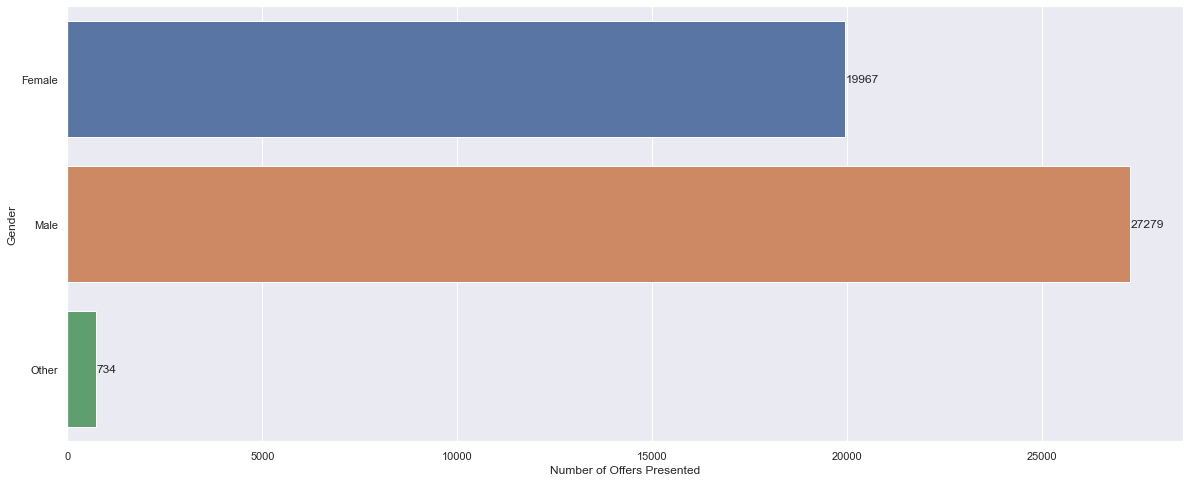

In [58]:
genders = pd.DataFrame({'Gender':offer_instance.apply(lambda x: 'Other' if (x.customer_gender_M == 0 and x.customer_gender_F == 0) else ('Female' if x.customer_gender_F == 1 else 'Male'), axis=1)})
plt.figure(1, figsize = (20 , 8))
ax = sns.countplot(y = 'Gender' , data = genders)
ax.set(xlabel='Number of Offers Presented', ylabel='Gender')
# ax.set_yticklabels(['Female', 'Male'])
ax.bar_label(container=ax.containers[0], labels=[genders.value_counts()['Female'], genders.value_counts()['Male'], genders.value_counts()['Other']])
plt.show()

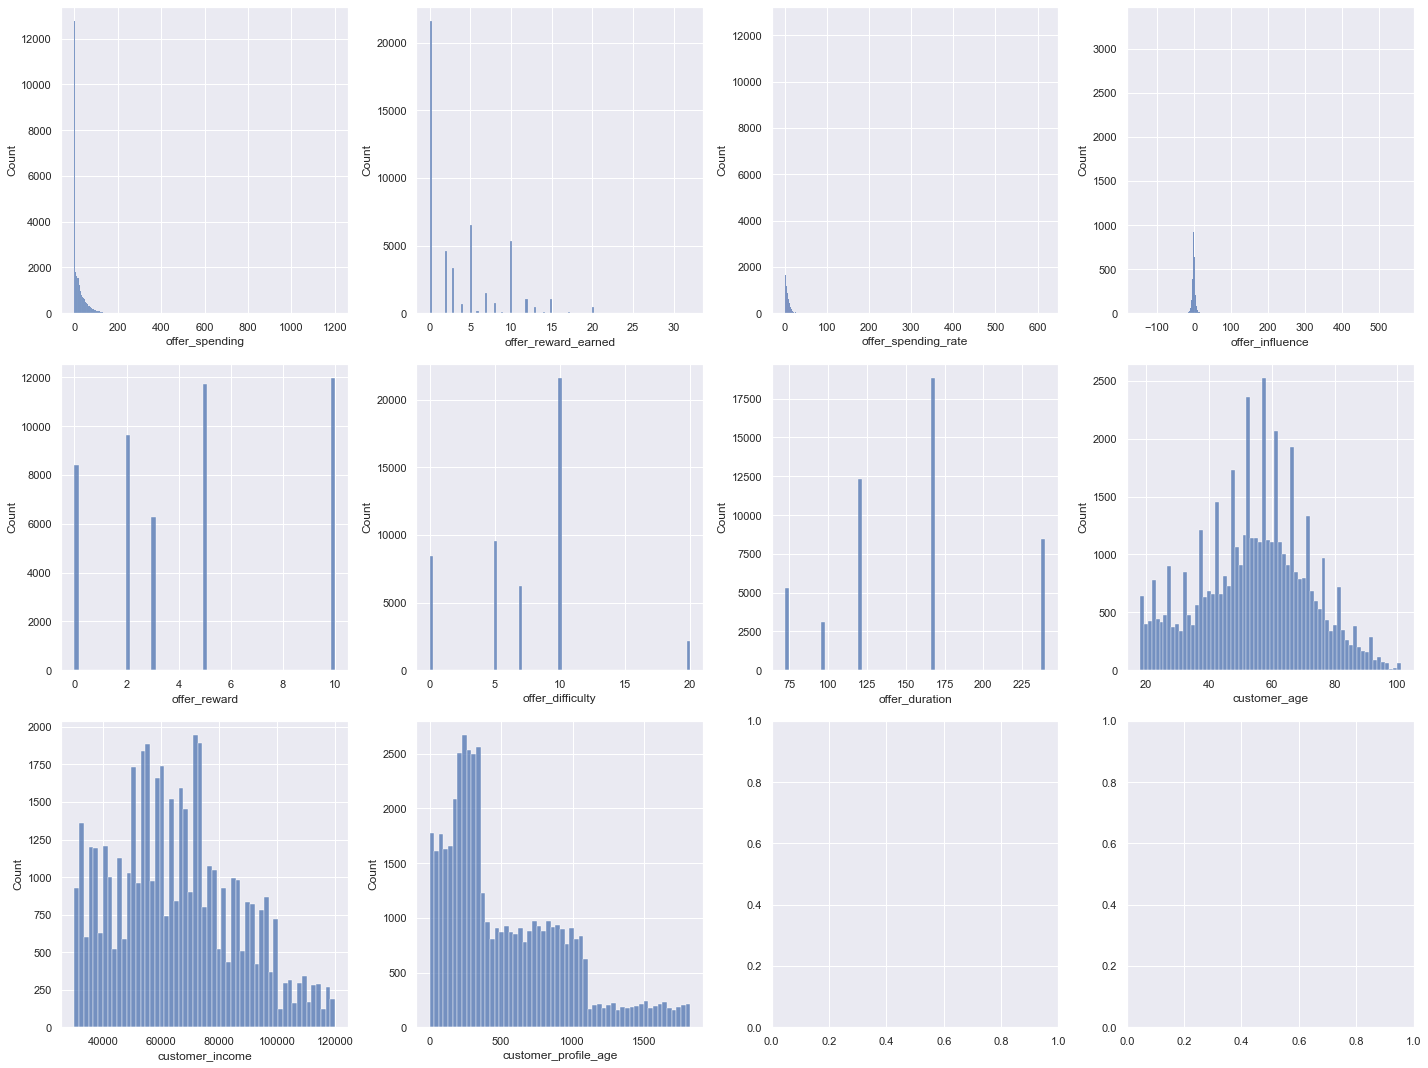

In [59]:
histogram_variables = offer_instance.drop(columns=[
    'offer_id',
    'person',
    'offer_start_time',
    'offer_end_time',
    'offer_view_time',
    'channel_email',
    'channel_mobile',
    'channel_social',
    'channel_web',
    'offer_type_bogo',
    'offer_type_discount',
    'offer_type_informational',
    'customer_gender_M',
    'customer_gender_F',
    # Counts of customer attributes across offer_instances are not meaningful:
    'customer_total_spending',
    'customer_total_no_offer_spending',
    'customer_total_offer_spending',
    'customer_days_without_offer',
    'customer_days_with_offer',
    'customer_no_offer_spending_rate',
    'customer_offer_spending_rate',
    'customer_average_offer_influence',
    'average_offer_spending_rate',
])
# Create a figure and a set of subplots with as many rows as needed and 4 columns
num_rows = (len(histogram_variables.columns) + 2) // 4  # Calculate the number of rows needed
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20,15))

# Create a histplot for each column in the DataFrame
for i, col in enumerate(histogram_variables.columns):
    sns.histplot(data=histogram_variables, x=col, ax=axes[i // 4, i % 4])
plt.tight_layout()
plt.show()

We will create a group of pairwise scatter plots. The points shown in orange are the offer instances that resulted in the customer spending more than they do during the period whiule they have viewed other active offers.

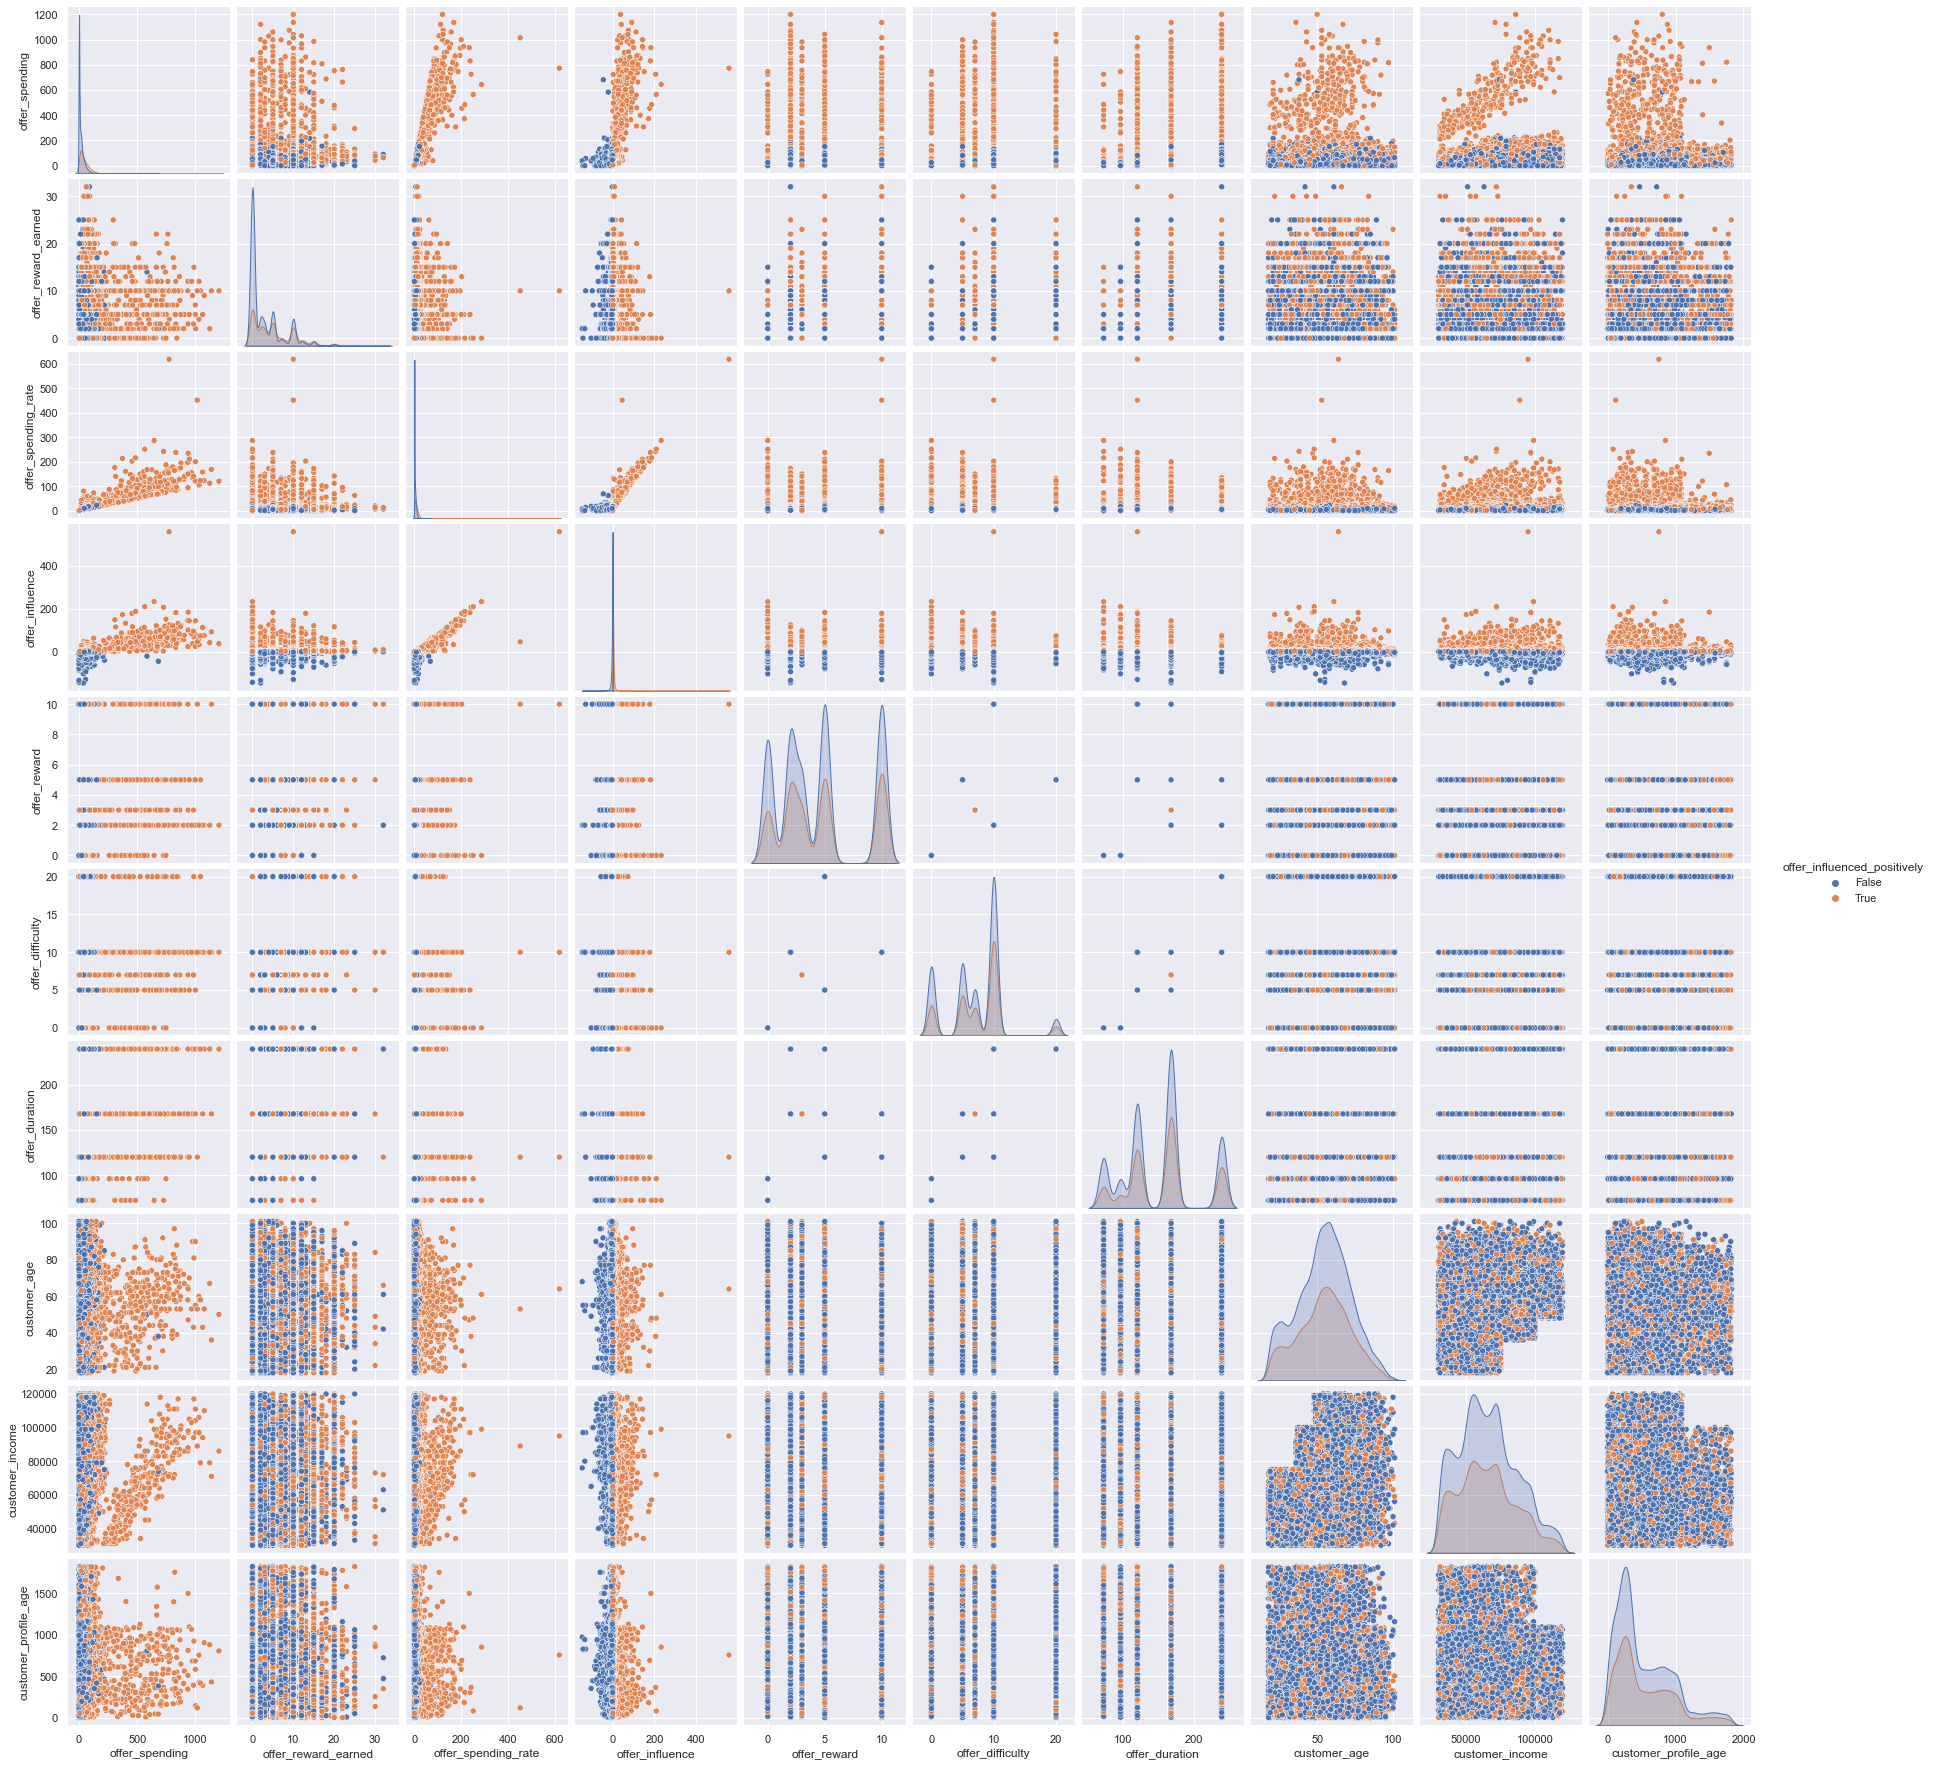

In [60]:
pairplot_variables = offer_instance.drop(columns=[
    'offer_id',
    'person',
    'offer_start_time',
    'offer_end_time',
    'offer_view_time',
    'channel_email',
    'channel_mobile',
    'channel_social',
    'channel_web',
    'offer_type_bogo',
    'offer_type_discount',
    'offer_type_informational',
    'customer_gender_M',
    'customer_gender_F',
    'customer_total_spending',
    'customer_total_no_offer_spending',
    'customer_total_offer_spending',
    'customer_days_without_offer',
    'customer_days_with_offer',
    'customer_no_offer_spending_rate',
    'customer_offer_spending_rate',
    'customer_average_offer_influence',
    'average_offer_spending_rate',
])
# We are adding this variable to color the offers that resulted in positive spending influence
pairplot_variables['offer_influenced_positively'] = pairplot_variables.offer_influence.apply(lambda x: x > 0)
sns.pairplot(pairplot_variables, hue='offer_influenced_positively');

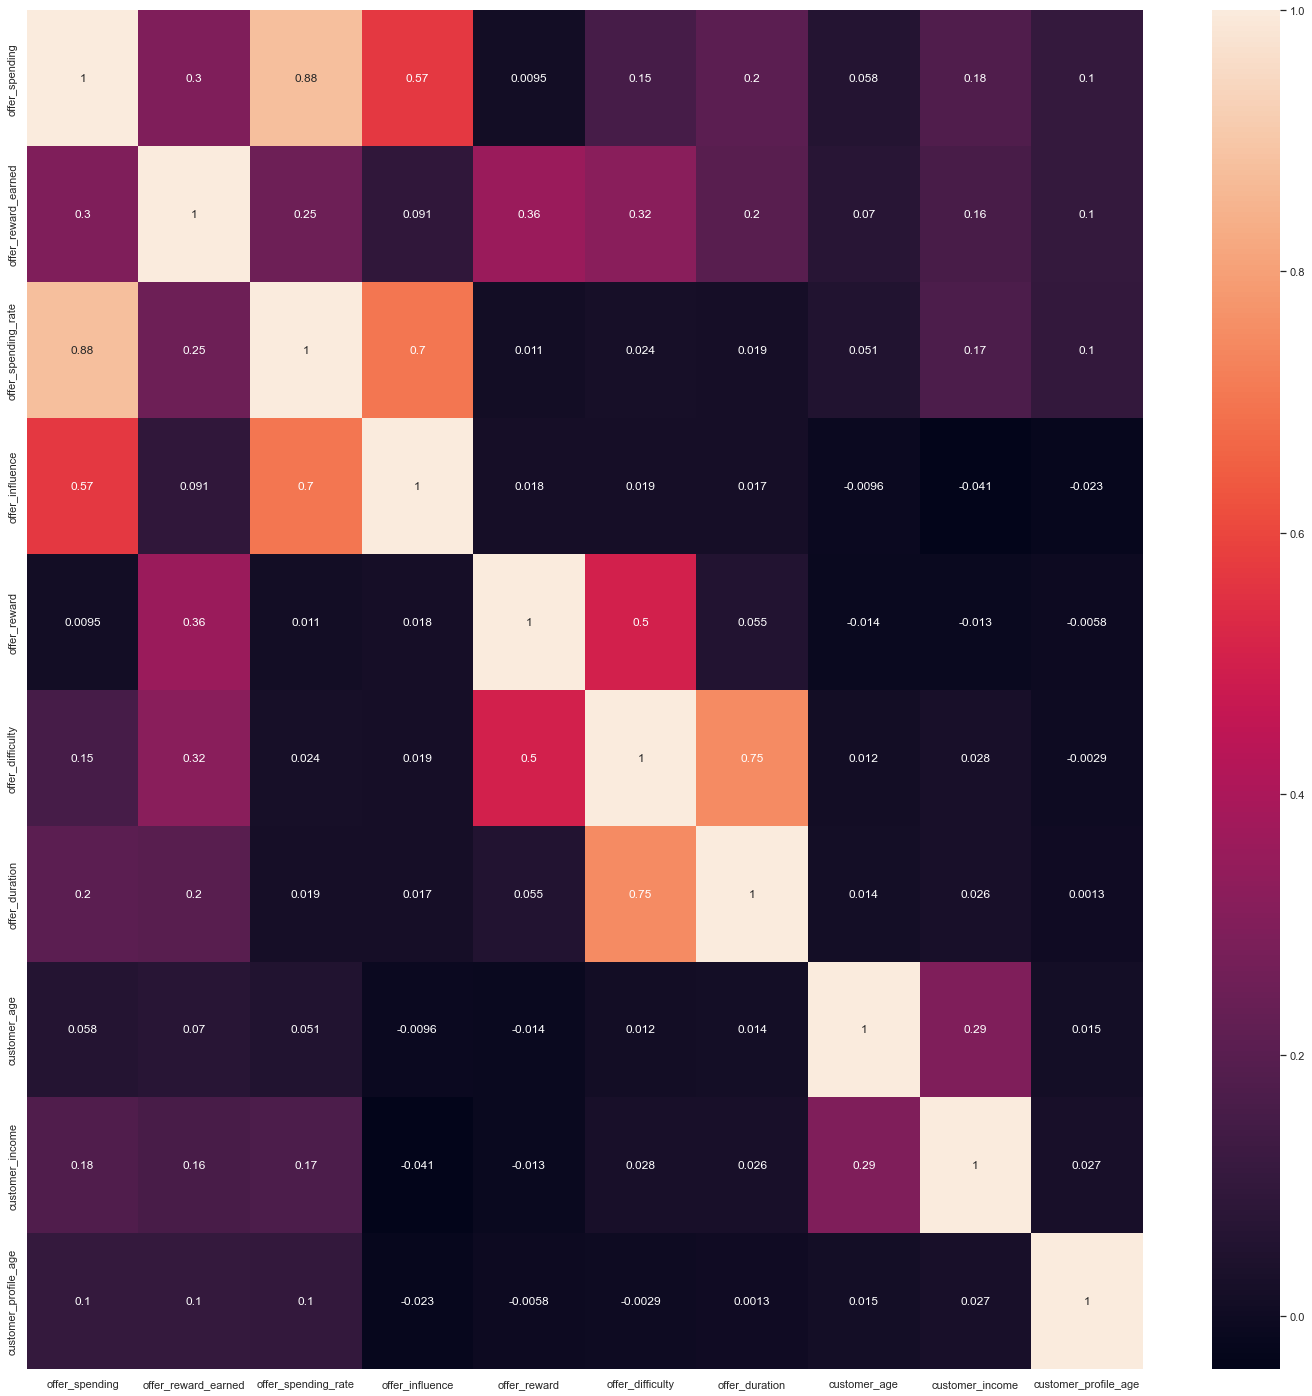

In [61]:
correlation_matrix_variables = offer_instance.drop(columns=[
    'offer_id',
    'person',
    'offer_start_time',
    'offer_end_time',
    'offer_view_time',
    'channel_email',
    'channel_mobile',
    'channel_social',
    'channel_web',
    'offer_type_bogo',
    'offer_type_discount',
    'offer_type_informational',
    'customer_gender_M',
    'customer_gender_F',
    'customer_total_spending',
    'customer_total_no_offer_spending',
    'customer_total_offer_spending',
    'customer_days_without_offer',
    'customer_days_with_offer',
    'customer_no_offer_spending_rate',
    'customer_offer_spending_rate',
    'customer_average_offer_influence',
    'average_offer_spending_rate',
])
# Correlation of the columns shown in a heatmap
plt.figure(figsize=(25,25))
sns.heatmap(correlation_matrix_variables.corr(),annot=True);

While we observed some correlations among customer attributes (e.g. customer income and customer age), offer attributes (offer duration and offer difficulty, offer reward and offer difficulty), the more interesting correlations are amoung the ones related to spending.

For example, we have found that offer influence is highly correlated (r = 0.7) with offer spending rate. While we cannot make causal inferences solely based on this, this may indicate that the spending of customers who spend more are more likely to be influenced by offers and spend even more.

This correlation is also visible in the scatter plot of offer spending rate and offer influence as the points appear to have tightly gathered around a line in that chart, showing the linear relationship between them.

## 3. Modeling
The dependent (target) variable `y` we are trying to predict is `offer_influence`. We want to create a model that provides us a predicted offer influence for a given set of offer attributes and a given set of profile attributes. So we will take the subset of the columns from the `offer_instance` df that contain the offer attributes and the profile attribute as the set of independent variables `x`.

In [62]:
x = offer_instance[['offer_reward',
                    'offer_difficulty',
                    'offer_duration',
                    'channel_email',
                    'channel_mobile',
                    'channel_social',
                    'channel_web',
                    'offer_type_bogo',
                    'offer_type_discount',
                    'offer_type_informational',
                    'customer_age',
                    'customer_income',
                    'customer_profile_age',
                    'customer_gender_M',
                    'customer_gender_F',
                    'customer_no_offer_spending_rate',
                    'customer_offer_spending_rate'
                    ]].to_numpy()
y = offer_instance['offer_influence'].to_numpy()

Split `x` and `y` into training and testing sets.

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

### Selecting the Best Regression Model
We will test the algorithms listed below and use the one that performs the best.

In [64]:
# Instantiate the algorithms and list the for the loop
lr = LinearRegression()
sv = SVR()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
mlp = MLPRegressor(max_iter = 250)
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
br = CatBoostRegressor()
sgd = SGDRegressor()
en = ElasticNet()
br = BayesianRidge()
lgbm = LGBMRegressor()

algorithms = [lr, sv, dt, rf, mlp, gb, xgb, br, sgd, en, br, lgbm]

algorithm_labels = [
    'Linear Regression',
    'Support Vector Regressor',
    'Decision Tree Regressor',
    'Random Forest Regressor',
    'MLP Regressor',
    'Gradient Boosting Regressor',
    'XGBoost Regressor',
    'CatBoost Regressor',
    'Stochastic Gradient Descent Regression',
    'Elastic Net Regression',
    'Bayesian Ridge Regression',
    'Light GBM Regressor'
    ]

In [65]:
# Metrics
mae = []
mse = []
rmse = []
r2s = []

In [66]:
# Train and test with each algorithm
for i, algorithm in enumerate(algorithms):
    print(f'Training and testing {algorithm_labels[i]}')

    # Train the model
    algorithm.fit(x_train, y_train)

    # Get the predictions for the test set
    predicted = algorithm.predict(x_test)

    # Evaluate the predictions for the test set, save the metrics
    mae.append(mean_absolute_error(y_test, predicted))
    mse.append(mean_squared_error(y_test, predicted))
    rmse.append(np.sqrt(mean_absolute_error(y_test, predicted)))
    r2s.append(r2_score(y_test, predicted))

Training and testing Linear Regression
Training and testing Support Vector Regressor
Training and testing Decision Tree Regressor
Training and testing Random Forest Regressor
Training and testing MLP Regressor
Training and testing Gradient Boosting Regressor
Training and testing XGBoost Regressor
Training and testing CatBoost Regressor
Training and testing Stochastic Gradient Descent Regression
Training and testing Elastic Net Regression
Training and testing Bayesian Ridge Regression
Training and testing Light GBM Regressor


In [67]:
# Gathering the test results in a df
result = pd.DataFrame({
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Square Error (RMSE)': rmse,
        'Explained Variance (R^2 Score)': r2s
    },
    index=algorithm_labels
    )
result.sort_values('Mean Squared Error (MSE)')

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Square Error (RMSE),Explained Variance (R^2 Score)
CatBoost Regressor,3.179383e+00,5.582883e+01,1.783082e+00,3.509845e-02
Bayesian Ridge Regression,3.179383e+00,5.582883e+01,1.783082e+00,3.509845e-02
Elastic Net Regression,3.177310e+00,5.584215e+01,1.782501e+00,3.486838e-02
Linear Regression,3.183127e+00,5.584587e+01,1.784132e+00,3.480410e-02
Support Vector Regressor,3.253764e+00,5.776814e+01,1.803819e+00,1.580973e-03
Gradient Boosting Regressor,3.215354e+00,6.861261e+01,1.793141e+00,-1.858462e-01
Light GBM Regressor,3.263086e+00,7.002995e+01,1.806401e+00,-2.103424e-01
Random Forest Regressor,3.597511e+00,7.655014e+01,1.896711e+00,-3.230323e-01
MLP Regressor,5.574712e+00,8.015261e+01,2.361083e+00,-3.852946e-01
XGBoost Regressor,3.349102e+00,8.337445e+01,1.830055e+00,-4.409782e-01


In [68]:
# Print the best algorithm for each metric
for column in result.columns.tolist():
    if column != 'Explained Variance (R^2 Score)':
        print(f'{result[column].idxmin()} resulted in the best {column}.')
    else:
        print(f'{result[column].idxmax()} resulted in the best {column}.')

Elastic Net Regression resulted in the best Mean Absolute Error (MAE).
CatBoost Regressor resulted in the best Mean Squared Error (MSE).
Elastic Net Regression resulted in the best Root Mean Square Error (RMSE).
CatBoost Regressor resulted in the best Explained Variance (R^2 Score).


Based on the results above, we will choose Support Vector Regressor as our predictor for offer influence. We chose this over Elastic Net Regression, which yielded the best MAE and RMSE because in addition to yielding the best MSE, Support Vector Regressor model explains the variance the best.

In [69]:
offer_instance.offer_influence.describe()

count    47980.000000
mean        -0.884398
std          8.520960
min       -146.617464
25%         -2.469900
50%         -0.482857
75%          0.714550
max        557.753574
Name: offer_influence, dtype: float64

The `offer_influence` variable is distributed as seen below. For any given set of profile attributes and offer attributes, our model will be able to predict the `offer_influence` with an average of $3.34 error.

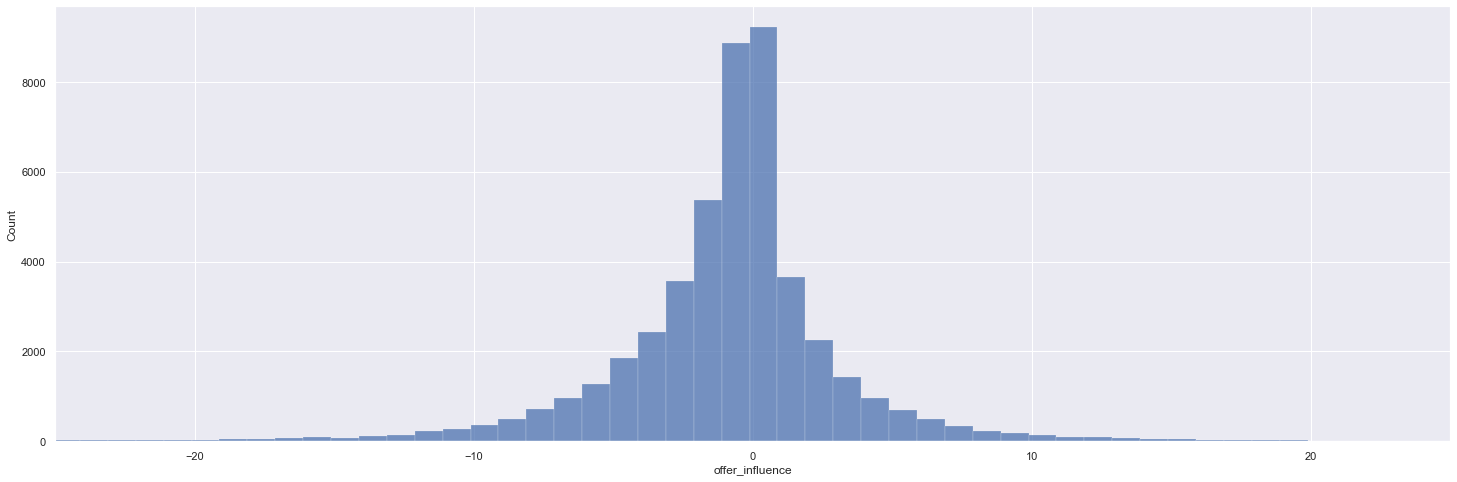

In [70]:
plt.figure(1, figsize = (25 , 8))
ax = sns.histplot(
    data=offer_instance,
    x='offer_influence',
    discrete=True,
    stat='count',
    
)
ax.set_xlim(-25,25);

## 4. Offer Decisioning Application

We now have a model that can predict the influence of a given offer for a given customer. We will save the selected model here to be used by the offer decisioning web application. This application allows the user to input a customer profile details and the application shows them the best offer for that profile.

You can see the code for this application in the `web-application` directory of this repository.

### Saving the Model and the Cleaned Data

In [71]:
# Export the cleaned data to csv files
offers.to_csv('data/offers-clean.csv')
profile.to_csv('data/profile-clean.csv')
transcript.to_csv('data/transcript-clean.csv')
offer_instance.to_csv('data/offer_instance-clean.csv')
offer_period.to_csv('data/offer_period-clean.csv')

# Save the model
with open('web-application/sv_model.pkl', "wb") as file:
    pickle.dump(sv, file)